# Single frequency denoising

This notebook uses the trained AR models to calculate the marginal of the warped frequency component.

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.AR
using LAR.DataAR
using FFTW
using Distributions

include("functions/auxiliary/buffer.jl")
include("functions/auxiliary/audioplayer.jl")
include("functions/auxiliary/workflow.jl")
include("functions/auxiliary/fourier.jl")
include("functions/auxiliary/warpedfilter.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file = "data/obama.wav"      # specify sound location
fs_desired = 16000                 # specify desired sampling frequency

# signal warping
nr_taps_warped = 32                # number of taps of warped filter bank
z_pole = 0.5756                    # pole location of all-pass filter segments (0.5756 ~ approximation Bark scale)
window = rectangularwindow         # specify windowing function from fourier.jl file

# inference and modelling
bin = 8                            # specify which bin to model (should be between 1 and half `nr_taps_warped`)
bin_c = "real"                     # specify whether to model the `real` or `imaginary` part
AR_order = 5                       # order of auto-regressive model
iterations = 3                     # number of iterations for variational message passing
Λ_meas = 400                       # assumed precision of measurement noise of a frequency component

# load model parameters
load_file = "inferred_values/speech_AR_05.h5" # file in which model parameters are present
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time)
x_time = x_time[24*fs_time+1:27*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 100*x_time/var(x_time)

# specify time axis
t = collect((1:length(x_time))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjzuAgBXQVZFZm10ICgAAAD+/wEAgD4AAAD6AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQDuAgA0lsw8VYUwPZMyNz3bmUQ96a0nPSd4ID2fCP08wi7MPE+VpTwghG48U3oEPBpI1TkrbOu7RjmSvHBO07z3Gvu8u+MGvT8bC71vv+a8FVrbvI++srxgZYO8GggcvL1frLt5IWq786PVOhtawjsBZuk752aCO/xfhjtLFfk7f9E6PBk3Zjw/KoM8g/ZrPDithTw6RIE8x1yBPFdtiTyclo48W96FPHP1jzz8ZoM8zEVIPMmU4jttqPy6nRoyvHXdr7wGjOS8n1MAvU/sBr277w299hEavR2OF717swC9X2m4vHD5k7xL71K8bQFvu5ra1DuMO4E8Qkb7POQbLj1iUVA9PFZmPXvcgj1UDYU9Ecd8PdFPcz1lj1w9H0ZEPauyNj0kdyY9jIYdPTI7DD3jC/g8QDbePDnkzTzmisU8zc28PNpHmDzm0ks8I1awO0MLZrvofx68OtV6vCOikbwCVHq8hk15vCQCerzXvGK8aYxUvPBV/ruccS+7ZIf/OprdWjv/6pu5LUYROh4yejuY5W88p/CuPHEO7jwe+BQ9KnQuPTrYND1NjjA9exgkPeW9DT0tsdw89h+NPGAdqzua1we8yEqsvH+DAr2HEiK9HFI/vTdbVr3JlXq9PpCHvR32kL38KZO9zPyKvV6wdb1rCFe98qMzvQExFb2pqsy8PjdLvESArLuLm4s7BwlDPGjGojwLwcM8qZysPB5ChjzvxVk8ixzyO7p5zDkTc6G7d10uvCXld7wBVq+8yKfxvCzwHL3q9yC9axMeveYTF73aaAy96wvcvFG+p7yAL4S8AWhbvNAfMLzdxjW8EQSBvCQOfLyNUSu85IKBu1BGrLpJY7U5Rv92O0aZGTzx8HA873GEPNTjhTxvlp88vX61PLH9vjzFyqw88MiXPBrHgjyhfRs8qW13O4b+b7uBrEO8m3DBvGosDb3NWjG9a5c+vUy8S73LAVC91ZZKvTyGOL25KyO9Hl8DvQlup7zgvEe8Z2RFu9Fu6DsscYU8uJbHPNKOBD1Nkh89NVg6PRgaPj2LdDo9p/svPa6zGj2gWOw8HKuWPIghIDy6D307OqG1us4zsLuqkyy8PhOIvB19try/rwC9nGEfvfHEOr16JlG9iI5mvZ0Ebb2abW29bzNnvWpcYb0X5Ei9EZIavdEC4bzY7o+8aEY6vLyBtbs/fBk5bpfDOypN7ztsbz08klaFPAzLnTzCO548A7qnPFJcozyCv5k8Ot+IPJUGrzxDHrI88t3TPDWJ7jyNufs8Bu39PNVi7Txl8MU8u0eJPGmw7jtr5O664ukhvFd3mLxiB7m8kmbOvDXbyLyHxru8YniwvHsrp7zEyY68JEp1vJRyJLwNETO72z9ZO05vLjx+26Q8XLD2PEiWGz0pRTw9VyRMPS1DST0YFkM9VI44PWonHj2zJPI83l6oPBUPGzw9IJK7VLV/vFKv07xHaAm93K4bvZRAOL2lej29ONREvfUNVr2X7Vm9T0NdvVgOYr0C0G29PfhtvXP+bL29WWK9gklYvTNySr24DTW9LpIMvbat3Lyr5LG8Cw6MvE0yKrwURc27V1ebuyTJnrs4Z/m5mbQlOyrRmjvbr6w7Gu+tO5VZfDs/hY64wl6uukuxn7uOfQS828CNvOrMxbwzeuu8jy79vCpX/7z34gy9sD8cvd2ZD720eOa8BQ+svDJRCbyPxuE7jZq5PJV/Ez26FD49ao5YPRTubj2f4nk90Kl6PTwAcD0CYlY9KZ09PezgGz3CGAY9+0bkPDpiuTziYXc8yhgKPOuO2rlk5yG8/+W0vCrgAb2QCCO9v6c5vd0KQb3IiTq94zYnvWTmHL1UAgq94w7svG/tuLztTpG8ZvhUvH4RIbxaiyi8e28rvExn97tTE6K7fPgsOhnlwjuIPUo8QDKKPEexrDwqOrI8yE+/PFXnyzxENNA8pjLXPPAs6DxHG8g8OBqTPHWpFjyyHLe6K3NjvEdC4LzJlRW9a7s0vWqqRr09K1u9zb5kvQK+ab1THWO9O+4/vdCTEb3Qt7u8zHQZvNM3WzsS+IY8pqDVPNglDz1L0Cc9K307PdVZWT0yJWw9hciAPWklgT38hnE9arFZPTSwPz2BbTQ9kccePajM/Ty71rY8AWqRPNzSeTwMHFE8uMxQPBBTYTzlSUc8UHBtPH8UUjyJLz48tb8SPFVlkTsKwsI6jVmAuhzoF7tAAa66xaLHOjIfiTtqUSM859SFPMjRnTzZiqM8b36vPGv2rzwUc7k8hC3EPK6S3DwpDec8u6gFPaj2Hj3aPy49Bg85PXg3MT20JRc9pczIPKBlJzwsrsa7BSKMvIZRyLzfSve8KFMWvVM4Mb1EZD69n1ZXvbFRbr2bFnu95wVvvfX0XL1LTEm9DuM2vT6PFL1t2Ni8Kd+EvIZzzrv5B0o7cixhPGCKpzx5kLk845apPFhvjTyuIm48B2Q3PDz7BTxhI4k73UKRuknYtbvASk+8WcyavIKH2rwhthS9hXArvcTXOb1bMUO9BrhFvSd2Pb2gria9WdgPvUFQ1ryQNIi8P18XvBCemrnEs1Y7eGwUPOAfRDwg3zI8vuwbPLDTAjye7Nc7asz5Ow6s4juf8vI7tuj3O8U4mzve7E87h7uiOutPz7rRUZC73oYEvM9RTrxtq8G8ag0AvTtfHb2wVj69ey5Qvfb5Xr1aD2u9Fl9wvaw4bb2EG2O97hVQvfEoOb1cKhe9O37gvE7HhrwKlXq7RnLKO+/tXTyxQb08f8gMPUb+OT34tGM9eNtxPfZjcj0NyV09R+E1PZFRET2ujro8XU9cPA6tBDxnN1E7wdWbuqUHlLvzCQm8SERYvCJXkrzlXqC8VHuwvN1kuby7u7e8G1XAvNIP1rwCIe+8ZSX9vBGqAb3/LO+8VU3ZvHJnmbyrKXC8Y10tvOqItLvcX+U6l6YNPC1GWTzUPok8yDyZPA0zrTy7hMU8J+7SPAQp0Dzfydw8FDrlPEsw8TxKQ/U80ZfhPCR7sDwqmXU8pyYhPId8AzzV3wI84pHQO/UQlzoCtoi73aTju8Ld47sj9/G7Pm71u5rOo7uvohK73IJaO73QJzy+foY8MgmyPDD73DzCJAw9XNoePSBpJD1cfR49bjoePQQ/GT0/qBw9Cr4ePTpoHT23rws9XsT+PO5u0zwvgJE8vQgIPMfdJ7vnCUW8nG+TvBMKqbwhNMi8YYLkvGbP9LzgDQG91zgDvYt1E724hSO9ua4uvXuPN71HBzW9CHo1vSUPOL11TC299eMcvQXQDr3qUAC9z1PxvM0X4bx9V8a8kh6evEgfSrzXJhG8z8k4u4wvAzuYWYQ7IFh7Oxm31rla3va7Het9vPfZy7x16wi9cGEivQH9Qb2CQWG9UYpsvbMscL0MDmi9EKZdvUyoQb1f2x29DPcKvQZ7xbyLcne8wYm3u34PwDuhznE8J0u+PP9HDD0CTCY9SA4+PZEUQD2WBzE9NeolPcRaCD1ha9s8oECGPDGiEDyI7OQ7kUTIOlC0hbtT1C2894KvvHi08LzxZA+9omoZvaUeCr0gPAO9t+kDvVAu7LzsqNa8s5quvMwAp7yWhpe8ujlKvIB6C7wiEZW7wI4dOjNfYTuZIa071KjmO9WnKjx0CV48IcqNPEO9szzNab48Zj7UPAVa1zy2etg8qVfePO+Z0TyQpNI8Pka9PPBDqzw8oG08Qw8APJ0ziTrFeDO8earBvC3HCb0t+TG9NzpSvRLqab1Cx229F7RuvTJmar2Uxk29JQEzvZk8Er3Y0Nu8ww2JvP0uFbwkubg67EMlPIIaqTzWCwI9m/QbPQJWHz37Dx09/9ANPeEw6zyMhK88z1hkPNNuHzwCfgI7J/+AuhDst7uat

## Visualize data

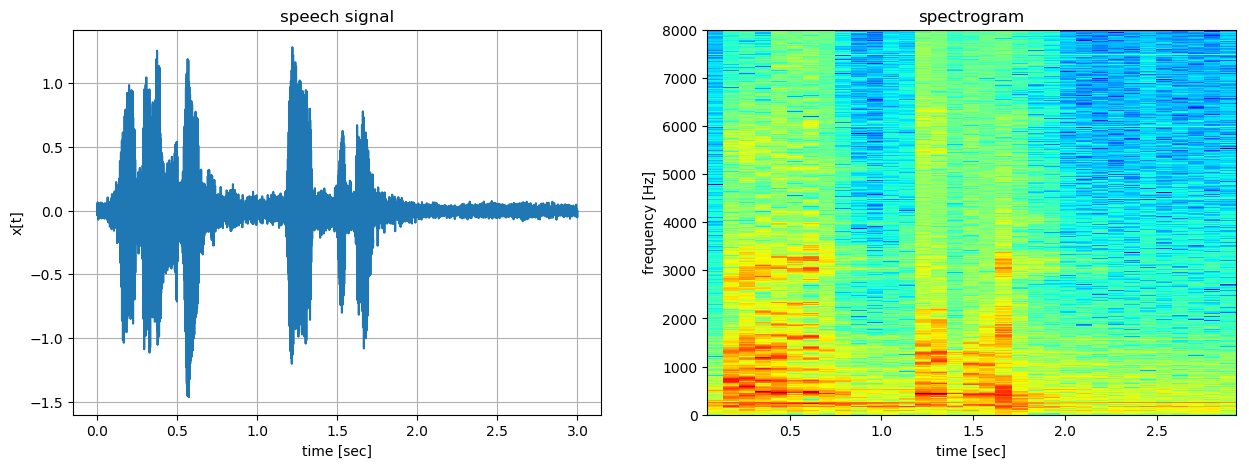

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_time)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Warp signal and calculate warped frequency distribution

In [5]:
# initialize memory vector of taps, Y, with zeros
Y = zeros(nr_taps_warped*3,1)

# initialize memory struct for filter taps and spectrum coefficients
mem_taps = Array{Array{Float64,1}}(undef, length(x_time))
mem_spec = Array{Complex{Float64},2}(undef, length(x_time), nr_taps_warped)

# get update matrices as defined in thesis
W, U = allpass_update_matrix(nr_taps_warped, z_pole)

# loopt through time-domain signal
for k = 1:length(x_time)
    
    # update memory vector of taps and taps themselves
    Y, mem_taps[k] = allpass_update(x_time[k], Y, nr_taps_warped, z_pole, T=W, u=U)

    # calculate windowed FFT of taps
    mem_spec[k,:] = FFTW.fft(window(nr_taps_warped).*mem_taps[k])
    
end

# discard frequency components concerning non-positive frequencies (are complex conjugate, because of real temporal signal)
if nr_taps_warped%2 == 0
    mem_spec = hcat(mem_spec[:, 2:Int(nr_taps_warped/2)], conj.(mem_spec[:, Int(nr_taps_warped/2)+1]))
else
    mem_spec = mem_spec[:, 2:Int(ceil(nr_taps_warped/2))]
end

# calculate real and imaginary parts of remaining frequency components
mem_spec_real = real(mem_spec)
mem_spec_imag = imag(mem_spec)
mem_spec_all = hcat(mem_spec_real, mem_spec_imag)
mem_spec_all_clean = mem_spec_all
mem_spec_all = mem_spec_all + rand(Distributions.Normal(0, 1/sqrt(Λ_meas)), size(mem_spec_all))

# output signal
filter_output = [mem_taps[k][end] for k = 1:length(mem_taps)]
;

## Visualize noisy frequency component

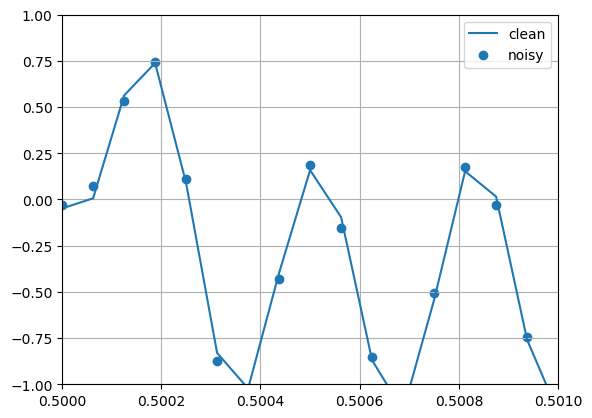

PyObject <matplotlib.legend.Legend object at 0x000000004FDF5940>

In [6]:
plt.plot(t,mem_spec_all_clean[:,bin], label="clean")
plt.scatter(t,mem_spec_all[:,bin], label="noisy")
plt.xlim(0.5, 0.501)
plt.ylim(-1, 1)
plt.grid()
plt.legend()

## Warped spectral distribution visualization

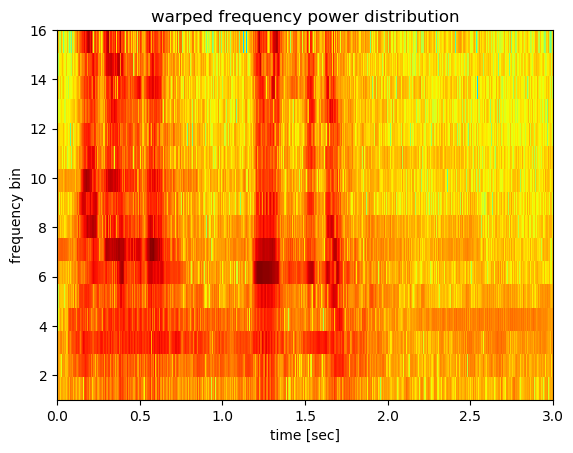

In [7]:
# calculate power of spectral components
mem_spec_pwr = 20*log10.(abs.(mem_spec))'

# plot warped power spectrum
plt.imshow(mem_spec_pwr, aspect="auto", cmap="jet", origin="lower", extent=[t[1], t[end], 1, Int(floor(nr_taps_warped/2))]), plt.xlabel("time [sec]"), plt.ylabel("frequency bin"), plt.title("warped frequency power distribution")
;

## Generative model

In [8]:
# create factor graphs
fg = FactorGraph()

# AR node
@RV γ ~ ForneyLab.Gamma(placeholder(:a_γ), placeholder(:b_γ))
@RV θ ~ GaussianMeanPrecision(placeholder(:μ_θ, dims=(AR_order,)), placeholder(:Λ_θ, dims=(AR_order, AR_order)))
@RV Sprev ~ GaussianMeanPrecision(placeholder(:μ_Sprev, dims=(AR_order,)), placeholder(:Λ_Sprev, dims=(AR_order, AR_order)))
@RV S ~ LAR.AR.Autoregressive(θ, Sprev, γ)

# selection and input
d = zeros(AR_order)
d[1] = 1
@RV x ~ DotProduct(d, S)
@RV v ~ GaussianMeanPrecision(0, Λ_meas)
@RV y = x + v
placeholder(y, :y)

ForneyLab.draw(fg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 15915296007255931898 -->
 15915296007255931898 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 15223727646459143597 -->
 15223727646459143597 
 
 clamp_2 
 
<!-- 15915296007255931898--15223727646459143597 -->
 15915296007255931898--15223727646459143597 
 
 clamp_2 
 1 out 
 2 m 
 
<!-- 8214039281785557667 -->
 8214039281785557667 
 
 clamp_3 
 
<!-- 15915296007255931898--8214039281785557667 -->
 15915296007255931898--8214039281785557667 
 
 clamp_3 
 1 out 
 3 w 
 
<!-- 16676511137014639027 -->
 16676511137014639027 
 
 Gam 
 gamma_1 
 
<!-- 13015254453495504467 -->
 13015254453495504467 
 
 placeholder_a_γ 
 
<!-- 16676511137014639027--13015254453495504467 -->
 16676511137014639027--13015254453495504467 
 
 a_γ 
 1 out 
 2 a 
 
<!-- 1914317374186559215 -->
 1914317374186559215 
 
 placeholder_b_γ 
 
<!-- 16676511137014639027--1914317374186559215 -->
 16676511137014639027--1914317374186559215 
 
 b_γ 
 1 out 
 3 b 
 
<!-- 3435150193080477203 -->
 3435150193080477203 
 
 placeholder_μ_Sprev 
 
<!-- 2442236418908010573 -->
 2442236418908010573 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 13533511648986258952 -->
 13533511648986258952 
 
 placeholder_μ_θ 
 
<!-- 2442236418908010573--13533511648986258952 -->
 2442236418908010573--13533511648986258952 
 
 μ_θ 
 1 out 
 2 m 
 
<!-- 5705669062309479362 -->
 5705669062309479362 
 
 placeholder_Λ_θ 
 
<!-- 2442236418908010573--5705669062309479362 -->
 2442236418908010573--5705669062309479362 
 
 Λ_θ 
 1 out 
 3 w 
 
<!-- 2518511387508740005 -->
 2518511387508740005 
 
 placeholder_Λ_Sprev 
 
<!-- 12638001799388027739 -->
 12638001799388027739 
 
 + 
 addition_1 
 
<!-- 12638001799388027739--15915296007255931898 -->
 12638001799388027739--15915296007255931898 
 
 v 
 1 out 
 3 in2 
 
<!-- 18222170960764030758 -->
 18222170960764030758 
 
 dot 
 dotproduct_1 
 
<!-- 12638001799388027739--18222170960764030758 -->
 12638001799388027739--18222170960764030758 
 
 x 
 1 out 
 2 in1 
 
<!-- 6163822657732724055 -->
 6163822657732724055 
 
 AR 
 autoregressive_1 
 
<!-- 6163822657732724055--16676511137014639027 -->
 6163822657732724055--16676511137014639027 
 
 γ 
 1 out 
 4 γ 
 
<!-- 6163822657732724055--2442236418908010573 -->
 6163822657732724055--2442236418908010573 
 
 θ 
 1 out 
 3 θ 
 
<!-- 11913473395792460218 -->
 11913473395792460218 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 6163822657732724055--11913473395792460218 -->
 6163822657732724055--11913473395792460218 
 
 Sprev 
 1 out 
 2 x 
 
<!-- 11913473395792460218--3435150193080477203 -->
 11913473395792460218--3435150193080477203 
 
 μ_Sprev 
 1 out 
 2 m 
 
<!-- 11913473395792460218--2518511387508740005 -->
 11913473395792460218--2518511387508740005 
 
 Λ_Sprev 
 1 out 
 3 w 
 
<!-- 6662384634894493543 -->
 6662384634894493543 
 
 clamp_1 
 
<!-- 18222170960764030758--6163822657732724055 -->
 18222170960764030758--6163822657732724055 
 
 S 
 1 y 
 3 in2 
 
<!-- 18222170960764030758--6662384634894493543 -->
 18222170960764030758--6662384634894493543 
 
 clamp_1 
 1 out 
 2 in1 
 
<!-- 8543859368268538069 -->
 8543859368268538069 
 
 placeholder_y 
 
<!-- 8543859368268538069--12638001799388027739 -->
 8543859368268538069--12638001799388027739 
 
 y 
 1 out 
 1 out

In [9]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(S, Sprev, ids=[:S :Sprev])
algo = compatibility_fix(variationalAlgorithm(q))

# evaluate algorith 
eval(Meta.parse(algo))
;

## Load parameters

In [10]:
# placeholder for parameters
params = Array{Dict{String, Union{Array{Float64}, Float64}}, 1}(undef, size(mem_spec_all)[2])

# load parameters
for k = 1:size(mem_spec_all)[2]
    if k <= size(mem_spec_all)[2]/2
        
        # load parameters of real coefficients
        params[k] = h5read(load_file, "bin_real_"*string(k, pad=2))     
        
    else
        
        # load parameters of imaginary coefficients
        params[k] = h5read(load_file, "bin_imag_"*string(k-Int(size(mem_spec_all)[2]/2), pad=2))     

    end
end
;

## Perform inference

In [11]:
# create placeholders for current values
current_μ_Sprev = randn(AR_order)
current_Λ_Sprev = tiny*diagm(randn(AR_order))

# create placeholder for marginals and data dictionary
marginals = Dict()
data = Dict()

# placeholder for spectral estimates
μ_x_pred = Float64[]
Λ_x_pred = Float64[]

# create progress bar
p = Progress(size(mem_spec_all)[1], 1, "Observed ")

# loop through signal samples
for sp in 1:size(mem_spec_all)[1]
    
    # update progress bar
    update!(p, sp)

    # update marginals
    marginals[:θ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=params[bin]["theta_mean"], w=params[bin]["theta_precision"])
    marginals[:γ] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=params[bin]["gamma_a"], b=params[bin]["gamma_b"])
    marginals[:Sprev] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=current_μ_Sprev, w=current_Λ_Sprev)

    # perform variational message passing iterations
    for it = 1:iterations

        # update data dictionary
        data = Dict(:y => mem_spec_all[sp, bin],
                    :μ_Sprev => current_μ_Sprev,
                    :Λ_Sprev => current_Λ_Sprev)    

        # perform inference
        data, marginals = step_all!(data, marginals)

        # update current parameters
        current_μ_Sprev = ForneyLab.unsafeMean(marginals[:Sprev])
        current_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:Sprev])

    end

    # update current parameters
    current_μ_Sprev = ForneyLab.unsafeMean(marginals[:S])
    current_Λ_Sprev = ForneyLab.unsafePrecision(marginals[:S])

    # save new marginals of x
    push!(μ_x_pred, current_μ_Sprev[1])
    push!(Λ_x_pred, current_Λ_Sprev[1,1])
end
;

Observed 100%|██████████████████████████████████████████| Time: 0:00:443:54


## Visualize denoised frequency component

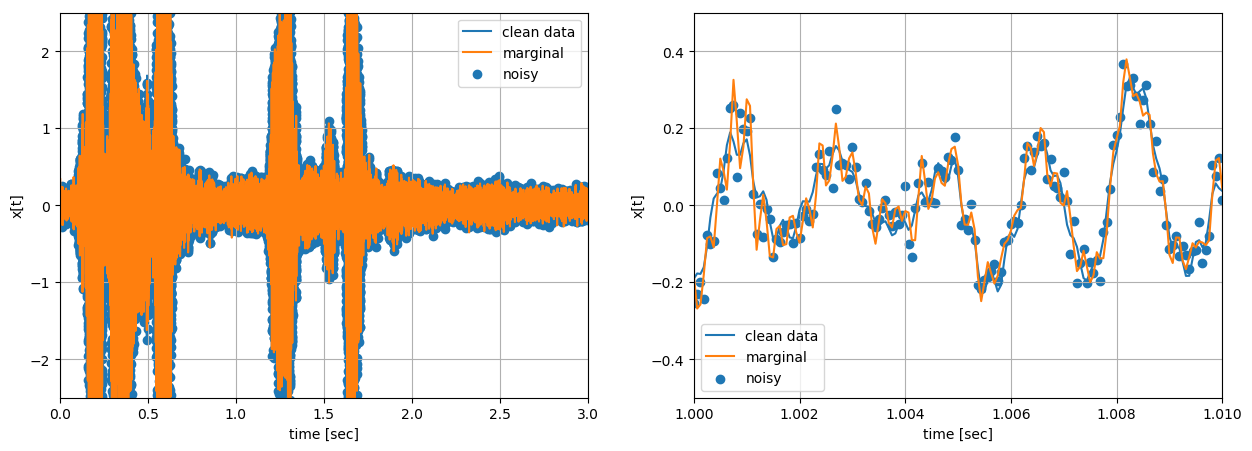

In [12]:
# create figure
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, mem_spec_all_clean[:,bin], label="clean data"), ax[1].scatter(t, mem_spec_all[:,bin], label="noisy"), ax[1].plot(t, μ_x_pred, label="marginal")
ax[2].plot(t, mem_spec_all_clean[:,bin], label="clean data"), ax[2].scatter(t, mem_spec_all[:,bin], label="noisy"), ax[2].plot(t, μ_x_pred, label="marginal")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-2.5, 2.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(1,1.01), ax[2].set_ylim(-0.5, 0.5), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()
;